# Report

In [1]:
from config import ASSETS_DIR, HYPERPARAMETERS_FILE, DATA_BASE_DIR, SEED
from utils import log, reporting, attention
import os
import json
import numpy as np
import plotly
import plotly.graph_objects as go
import pandas as pd
from sklearn import cluster, decomposition, manifold
import torch

logger = log.get_logger()

INFO:openml.config:No config file found at /home/uriel/.config/openml/config, using default configuration.


## General configurations and functions

In [2]:
OPTIMIZATION_METRIC = "log_loss"
OPTIMIZATION_MODE = "min"
EVALUATION_METRIC = "balanced_accuracy"

MAPPINGS = {
    "dataset_name": {
            "jasmine": "jasmine",
            "anneal": "anneal",
            "australian": "australian",
            "kr-vs-kp": "kr-vs-kp",
            "sylvine": "sylvine",
            "nomao": "nomao",
            "volkert": "volkert",
            "adult": "adult",
            "ldpa": "ldpa"
        },
    "aggregator_name": {
        "cls": "CLS",
        "concatenate": "CAT",
        "max": "MAX",
        "mean": "AVG",
        "rnn": "RNN",
        "sum": "SUM",
    }
}

DATASET_ORDER = ["jasmine", "anneal", "australian", "kr-vs-kp", "sylvine", "nomao", "volkert", "adult", "ldpa"]
AGGREGATOR_ORDER = ["CLS", "CAT", "RNN", "MAX", "AVG", "SUM"]
FEATURE_SELECTION_ORDER = ["attention", "decision_tree", "linear_model", "f_classif", "random"]
    
COLORS = ["#ffc5de", "#ffefd8", "#c7f7f7", "#d1d1d1", "#bedfff", "#e1c5ff"]
COLORS = plotly.colors.qualitative.Plotly

COLORS = ["rgba({}, {}, {}, 0.8)".format(*plotly.colors.hex_to_rgb(c)) for c in COLORS ]

HP_IMPORTANCE_TOP_K = [1, 5]
IMG_SCALE = 2.5

In [3]:
if not os.path.exists(ASSETS_DIR):
    os.makedirs(ASSETS_DIR)

## Best validation models

In [4]:
def num_as_str(x):
    return "{0:.3f}".format(x)

In [5]:
# Compute mean and std for each metric
# Compute mean and std for each metric
best_archs = pd.read_csv("cross_validation_scores.csv")

best_archs["dataset"] = best_archs["dataset"].replace(MAPPINGS["dataset_name"])
best_archs["aggregator"] = best_archs["aggregator"].replace(MAPPINGS["aggregator_name"])
best_archs[f"{EVALUATION_METRIC}_mean"] = best_archs[f"{EVALUATION_METRIC}_mean"] * 100
best_archs[f"{EVALUATION_METRIC}_std"] = best_archs[f"{EVALUATION_METRIC}_std"] * 100

assert best_archs.shape[0] == 3072, "The number of aggregated executions is wrong"
best_archs

,dataset,aggregator,architecture_name,attn_dropout,embed_dim,ff_dropout,n_head,n_layers,numerical_passthrough,optimizer__lr,...,log_loss_mean,log_loss_std,roc_auc_mean,roc_auc_std,f1_mean,f1_std,precision_mean,precision_std,recall_mean,recall_std
0,adult,CLS,A0,0.3,128,0.1,4,2,True,0.0001,...,0.313841,0.005949,0.782128,0.007264,0.905666,0.002347,0.891128,0.004609,0.920736,0.006608
1,adult,CLS,A1,0.3,128,0.1,4,2,False,0.0001,...,0.298849,0.006955,0.786045,0.006501,0.910700,0.002980,0.891587,0.004097,0.930703,0.007685
2,adult,CLS,A10,0.3,128,0.1,8,3,True,0.0001,...,0.316315,0.005494,0.781634,0.011839,0.904706,0.002698,0.891279,0.007803,0.918682,0.010316
3,adult,CLS,A11,0.3,128,0.1,8,3,False,0.0001,...,0.299645,0.006269,0.790115,0.006428,0.910603,0.002414,0.894338,0.004550,0.927537,0.008208
4,adult,CLS,A12,0.3,128,0.1,8,4,True,0.0001,...,0.317639,0.006076,0.781732,0.010861,0.904602,0.002478,0.891367,0.007112,0.918345,0.009063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,volkert,SUM,A59,0.3,256,0.1,32,3,False,0.0001,...,0.986028,0.016224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3068,volkert,SUM,A61,0.3,256,0.1,32,4,False,0.0001,...,0.989968,0.018868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3069,volkert,SUM,A63,0.3,256,0.1,32,5,False,0.0001,...,1.002055,0.019389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3070,volkert,SUM,A7,0.3,128,0.1,4,5,False,0.0001,...,0.995919,0.014608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Load hyperparameter space
with open(HYPERPARAMETERS_FILE, "r") as f:
    hyperparameters = json.load(f)
    
hyperparameters = {
    **hyperparameters["parameters"],
    **hyperparameters["rnn_parameters"],
}

fixed_hyperparameters = { k: v[0] for k, v in hyperparameters.items() if len(v) == 1 }
search_hyperparameters = { k: v for k, v in hyperparameters.items() if len(v) > 1 }

### Per dataset & aggregator

In [7]:
# Get registers with the lowest optimization metric
best_archs_ds_agg = best_archs.loc[reporting.get_top_k_indices(
                                        best_archs.groupby(["dataset", "aggregator"]),
                                        1,
                                        f"{OPTIMIZATION_METRIC}_mean",
                                        OPTIMIZATION_MODE
                                        )
                                  ]

assert best_archs_ds_agg.shape[0] == 54, "The number of optimal architectures is wrong"


# Adds a column to format Latex
best_archs_ds_agg[EVALUATION_METRIC] = "$" + best_archs_ds_agg[f"{EVALUATION_METRIC}_mean"].apply(num_as_str) \
                                + " \pm " + best_archs_ds_agg[f"{EVALUATION_METRIC}_std"].apply(num_as_str) + "$"

# Exports best dataset-aggregator configuration

best_archs_ds_agg = best_archs_ds_agg[["dataset", "aggregator", EVALUATION_METRIC]] \
                        .pivot(index="dataset", columns="aggregator") \
                        .reset_index()
best_archs_ds_agg.columns = [col[1] for col in best_archs_ds_agg.columns]

best_archs_ds_agg = best_archs_ds_agg.sort_values("", key=lambda x: x.apply(DATASET_ORDER.index))
best_archs_ds_agg = best_archs_ds_agg[[""] + AGGREGATOR_ORDER]

with open(os.path.join(ASSETS_DIR, "ds_agg_baccuracy_cv.tex"), "w") as f:
    f.write(best_archs_ds_agg.to_latex(index=False))
    
best_archs_ds_agg

,,CLS,CAT,RNN,MAX,AVG,SUM
3,jasmine,$81.201 \pm 1.161$,$80.352 \pm 1.511$,$82.381 \pm 0.795$,$81.763 \pm 1.771$,$81.421 \pm 1.468$,$80.560 \pm 1.277$
1,anneal,$95.677 \pm 8.887$,$95.260 \pm 8.680$,$90.594 \pm 11.434$,$91.224 \pm 10.439$,$91.391 \pm 11.575$,$90.477 \pm 10.815$
2,australian,$85.082 \pm 2.604$,$86.107 \pm 3.312$,$85.565 \pm 3.405$,$86.261 \pm 3.544$,$86.008 \pm 3.801$,$86.679 \pm 2.629$
4,kr-vs-kp,$99.802 \pm 0.245$,$99.884 \pm 0.169$,$99.649 \pm 0.167$,$99.760 \pm 0.219$,$99.756 \pm 0.168$,$99.715 \pm 0.108$
7,sylvine,$94.890 \pm 0.404$,$94.110 \pm 0.327$,$94.621 \pm 0.632$,$94.524 \pm 0.454$,$94.276 \pm 0.714$,$94.060 \pm 0.493$
6,nomao,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$
8,volkert,$61.911 \pm 0.487$,$56.803 \pm 0.580$,$60.847 \pm 0.879$,$60.319 \pm 0.381$,$59.238 \pm 0.503$,$57.954 \pm 1.138$
0,adult,$78.604 \pm 0.650$,$79.006 \pm 1.302$,$79.007 \pm 1.168$,$78.759 \pm 1.269$,$78.900 \pm 1.124$,$78.311 \pm 1.142$
5,ldpa,$56.023 \pm 0.431$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$


In [8]:
# Get registers with the lowest optimization metric
best_archs_ds_agg = best_archs.loc[reporting.get_top_k_indices(
                                        best_archs.groupby(["dataset", "aggregator"]),
                                        1,
                                        f"{OPTIMIZATION_METRIC}_mean",
                                        OPTIMIZATION_MODE
                                        )
                                  ]

assert best_archs_ds_agg.shape[0] == 54, "The number of optimal architectures is wrong"


# Adds a column to format Latex
best_archs_ds_agg[OPTIMIZATION_METRIC] = "$" + best_archs_ds_agg[f"{OPTIMIZATION_METRIC}_mean"].apply(num_as_str) \
                                + " \pm " + best_archs_ds_agg[f"{OPTIMIZATION_METRIC}_std"].apply(num_as_str) + "$"

# Exports best dataset-aggregator configuration

best_archs_ds_agg = best_archs_ds_agg[["dataset", "aggregator", OPTIMIZATION_METRIC]] \
                        .pivot(index="dataset", columns="aggregator") \
                        .reset_index()
best_archs_ds_agg.columns = [col[1] for col in best_archs_ds_agg.columns]

best_archs_ds_agg = best_archs_ds_agg.sort_values("", key=lambda x: x.apply(DATASET_ORDER.index))
best_archs_ds_agg = best_archs_ds_agg[[""] + AGGREGATOR_ORDER]

with open(os.path.join(ASSETS_DIR, "ds_agg_opt_cv.tex"), "w") as f:
    f.write(best_archs_ds_agg.to_latex(index=False))
    
best_archs_ds_agg

,,CLS,CAT,RNN,MAX,AVG,SUM
3,jasmine,$0.406 \pm 0.025$,$0.415 \pm 0.025$,$0.401 \pm 0.022$,$0.408 \pm 0.035$,$0.414 \pm 0.036$,$0.417 \pm 0.033$
1,anneal,$0.033 \pm 0.048$,$0.022 \pm 0.025$,$0.033 \pm 0.029$,$0.030 \pm 0.023$,$0.030 \pm 0.027$,$0.028 \pm 0.018$
2,australian,$0.318 \pm 0.054$,$0.323 \pm 0.055$,$0.332 \pm 0.052$,$0.323 \pm 0.051$,$0.329 \pm 0.061$,$0.318 \pm 0.060$
4,kr-vs-kp,$0.005 \pm 0.005$,$0.005 \pm 0.004$,$0.008 \pm 0.004$,$0.006 \pm 0.005$,$0.006 \pm 0.004$,$0.006 \pm 0.002$
7,sylvine,$0.147 \pm 0.009$,$0.164 \pm 0.013$,$0.154 \pm 0.015$,$0.164 \pm 0.013$,$0.161 \pm 0.014$,$0.170 \pm 0.013$
6,nomao,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$
8,volkert,$0.888 \pm 0.012$,$0.977 \pm 0.013$,$0.923 \pm 0.010$,$0.925 \pm 0.015$,$0.954 \pm 0.008$,$0.968 \pm 0.011$
0,adult,$0.299 \pm 0.007$,$0.301 \pm 0.004$,$0.299 \pm 0.006$,$0.299 \pm 0.005$,$0.299 \pm 0.007$,$0.301 \pm 0.005$
5,ldpa,$0.638 \pm 0.008$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$,$nan \pm nan$


### Per dataset

In [9]:
# Exports best dataset configuration
best_archs_ds = best_archs.loc[reporting.get_top_k_indices(
                                        best_archs.groupby(["dataset"]),
                                        1,
                                        f"{OPTIMIZATION_METRIC}_mean",
                                        OPTIMIZATION_MODE
                                        )
                                  ]

assert best_archs_ds.shape[0] == 9, "The number of optimal architectures is wrong"


# Adds a column to format Latex
best_archs_ds[EVALUATION_METRIC] = "$" + best_archs_ds[f"{EVALUATION_METRIC}_mean"].apply(num_as_str) \
                                + " \pm " + best_archs_ds[f"{EVALUATION_METRIC}_std"].apply(num_as_str) + "$"

# Exports best dataset configuration
best_archs_ds = best_archs_ds[["dataset", "aggregator"] + list(search_hyperparameters.keys()) + [EVALUATION_METRIC]]

best_archs_ds = best_archs_ds.sort_values("dataset", key=lambda x: x.apply(DATASET_ORDER.index))

with open(os.path.join(ASSETS_DIR, "ds_baccuracy_cv.tex"), "w") as f:
    f.write(best_archs_ds.drop(EVALUATION_METRIC, axis=1).to_latex(index=False))

best_archs_ds

,dataset,aggregator,n_layers,n_head,embed_dim,numerical_passthrough,balanced_accuracy
1441,jasmine,RNN,5,4,256,False,$82.381 \pm 0.795$
479,anneal,CAT,4,4,256,False,$95.260 \pm 8.680$
1117,australian,SUM,3,4,256,False,$86.679 \pm 2.629$
1633,kr-vs-kp,CAT,5,4,256,False,$99.884 \pm 0.169$
2712,sylvine,CLS,4,16,256,False,$94.890 \pm 0.404$
2304,nomao,CLS,2,4,128,True,$nan \pm nan$
2880,volkert,CLS,2,4,128,False,$61.911 \pm 0.487$
1,adult,CLS,2,4,128,False,$78.604 \pm 0.650$
2303,ldpa,SUM,2,8,128,False,$nan \pm nan$


## Best test models

In [10]:
best_archs_test = pd.read_csv("selected_architectures.csv")
best_archs_test["dataset"] = best_archs_test["dataset"].replace(MAPPINGS["dataset_name"])
best_archs_test["aggregator"] = best_archs_test["aggregator"].replace(MAPPINGS["aggregator_name"])
best_archs_test = best_archs_test.query("selection_metric == @OPTIMIZATION_METRIC")
best_archs_test[f"{EVALUATION_METRIC}_test_mean"] = best_archs_test[f"{EVALUATION_METRIC}_test_mean"] * 100
best_archs_test[f"{EVALUATION_METRIC}_test_std"] = best_archs_test[f"{EVALUATION_METRIC}_test_std"] * 100
best_archs_test[f"{EVALUATION_METRIC}_test_max"] = best_archs_test[f"{EVALUATION_METRIC}_test_max"] * 100
best_archs_test[f"{EVALUATION_METRIC}_test_min"] = best_archs_test[f"{EVALUATION_METRIC}_test_min"] * 100
best_archs_test = best_archs_test.sort_values("dataset", key=lambda x: x.apply(DATASET_ORDER.index))
best_archs_test[["dataset", f"{EVALUATION_METRIC}_test_mean", f"{EVALUATION_METRIC}_test_std", f"{EVALUATION_METRIC}_test_max", f"{EVALUATION_METRIC}_test_min"]]

,dataset,balanced_accuracy_test_mean,balanced_accuracy_test_std,balanced_accuracy_test_max,balanced_accuracy_test_min
3,jasmine,79.543885,2.100097,82.868908,77.661327
1,anneal,99.636364,0.813116,100.000000,98.181818
2,australian,87.900788,2.752097,90.195870,83.329785
4,kr-vs-kp,99.593421,0.207034,99.687473,99.223076
5,sylvine,95.202399,0.355764,95.661653,94.801980
6,volkert,56.147338,0.852821,57.103495,55.008948
0,adult,78.222632,0.119212,78.384178,78.069983


## Hyperparameters importance

In [11]:
color_map = {}
color_map["aggregator"] = { agg: color for agg, color in zip(MAPPINGS["aggregator_name"].values(), COLORS) }

for k, v in search_hyperparameters.items():
    color_map[k] = {agg: color for agg, color in zip(v, COLORS) }
    
label_map = {
    "aggregator": "{}",
    "n_layers": "{} layers",
    "n_head": "{} heads",
    "embed_dim": "{} dims",
    "numerical_passthrough": "{}"    
}

In [12]:
layout = go.Layout(
    margin={"l": 0, "r": 0, "b": 0, "t": 0},    
    template="plotly_white",
    font={"size": 22}
)

for top_k_value in HP_IMPORTANCE_TOP_K:

    best_archs_indices = reporting.get_top_k_indices(
        best_archs.groupby(["dataset"]),
        top_k_value,
        f"{OPTIMIZATION_METRIC}_mean",
        OPTIMIZATION_MODE
    )

    assert len(best_archs_indices) == 9 * top_k_value, "Best architectures indices got wrong"
    
    top_k_archs_df = best_archs[["aggregator"] + list(search_hyperparameters.keys()) ].loc[best_archs_indices]
    
    for c in top_k_archs_df.columns:
        
        labels = []
        values = []
        
        for prop, value in top_k_archs_df[c].value_counts(normalize=True).items():
            labels.append(prop)
            values.append(value)
            
        common_props = dict(
                            labels=[label_map[c].format(l) for l in labels], 
                            values=values, 
                            showlegend=False
                        )
        
        label_trace = go.Pie(**common_props, textinfo="label", textposition="outside")
        percent_trace = go.Pie(**common_props, textinfo="percent", textposition="inside")
            
        fig = go.Figure(data=[label_trace, percent_trace], layout=layout)
        fig.update_traces(
            marker=dict(
                    colors=[color_map[c][l] for l in labels]
            )
        )
        
        fig.write_image(os.path.join(ASSETS_DIR, f"t{top_k_value}_{c}_importance.svg"), scale=IMG_SCALE)
        
print("Done!")

Done!


## Cumulative attention

In [13]:
def load_attention_with_meta(dataset, selection_metric):
    data_dir = os.path.join(DATA_BASE_DIR, dataset)
    attention_file = os.path.join(data_dir, "feature_selection_cluster", selection_metric, "attention.npy")
    attention_file_info = os.path.join(data_dir, "feature_selection_cluster", selection_metric, "feature_selection_info.json")
    
    attn = np.load(attention_file)

    with open(attention_file_info, "r") as f:
        data_meta = json.load(f)
        
    return attn, data_meta

### Attention matrices

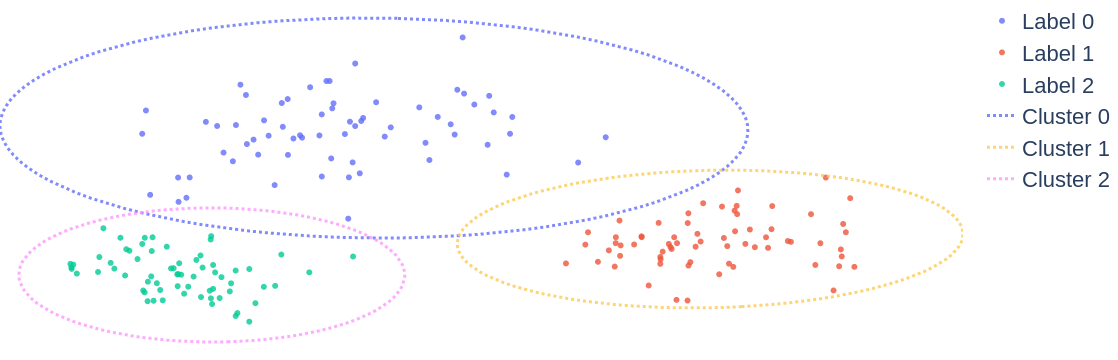

In [114]:
from sklearn import datasets

def ellipse_arc(x_center=0, y_center=0, ax1 = [1, 0],  ax2 = [0,1], a=1, b =1,  N=100):
    # x_center, y_center the coordinates of ellipse center
    # ax1 ax2 two orthonormal vectors representing the ellipse axis directions
    # a, b the ellipse parameters
    if not np.isclose(np.linalg.norm(ax1), 1) or not np.isclose(np.linalg.norm(ax2), 1):
        raise ValueError("ax1, ax2 must be unit vectors")
    if  abs(np.dot(ax1, ax2)) > 1e-06:
        raise ValueError("ax1, ax2 must be orthogonal vectors")
    t = np.linspace(0, 2*np.pi, N)
    #ellipse parameterization with respect to a system of axes of directions a1, a2
    xs = a * np.cos(t)
    ys = b * np.sin(t)
    #rotation matrix
    R = np.array([ax1, ax2]).T
    # coordinate of the  ellipse points with respect to the system of axes [1, 0], [0,1] with origin (0,0)
    xp, yp = np.dot(R, [xs, ys])
    x = xp + x_center 
    y = yp + y_center
    return x, y

def plot_attn_scatter(attn, labels, figure, cluster_labels=None, reduction_method=decomposition.PCA(n_components=2)):
    attn_plottable = reduction_method.fit_transform(attn)
    
    for l in np.unique(labels).astype(int):
        l_mask = (labels == l)
        fig.add_trace(go.Scatter(
                        name=f"Label {l}",
                        x=attn_plottable[l_mask, 0],
                        y=attn_plottable[l_mask, 1],
                        mode="markers",
                        marker=dict(
                            color=COLORS[l],
                            size=6
                        )
        ))

    if cluster_labels is not None:
        for c_l in np.unique(cluster_labels).astype(int):
            c_l_mask = (cluster_labels == c_l)

            c_attn = attn_plottable[c_l_mask]
            xs = c_attn[:, 0]
            ys = c_attn[:, 1]

            coefs = np.linalg.lstsq(
                            np.concatenate([xs[:, None], np.ones((xs.shape[0], 1))], axis=1), 
                            ys, rcond=None)[0]

            ax1 = np.array([1, 1 * coefs[0] + coefs[1]])
            ax1 = ax1 / np.linalg.norm(ax1)

            ax2 = np.array([1, -ax1[0] / ax1[1]])
            ax2 = ax2 / np.linalg.norm(ax2)
            
            x, y = ellipse_arc(
                    x_center=np.min(xs) + (np.max(xs) - np.min(xs)) / 2, 
                    y_center=np.min(ys) + (np.max(ys) - np.min(ys)) / 2, 
                    ax1=ax1,#[np.cos(np.pi/6), np.sin(np.pi/6)],  
                    ax2=ax2,#[-np.sin(np.pi/6), np.cos(np.pi/6)],
                    a=(np.max(xs) - np.min(xs)) * 0.7, 
                    b=(np.max(ys) - np.min(ys)) * 0.7
                )
            
            fig.add_trace(go.Scatter(
                        name=f"Cluster {c_l}",
                        x=x,
                        y=y,
                        mode="lines",
                        line=dict(
                            color=COLORS[-c_l],
                            width=3,
                            dash="dot"
                        )
                ))
        

    return fig
    
    
axis_template = dict(
                    showticklabels = False,
                    ticks="",
                    zeroline=False,
                    showgrid=False
                )

sim_attn, labels = datasets.make_blobs(n_samples=200, n_features=10, cluster_std=[6, 4, 3])

fig = go.Figure(layout=layout)
fig = plot_attn_scatter(sim_attn, labels, fig, cluster_labels=labels)

fig.update_layout(
        xaxis=axis_template,
        yaxis=axis_template
    )
fig.show()

In [18]:
dataset_labels_values = {
    "jasmine": -5,
    "anneal": -1.5,
    "australian": -0.8,
    "kr-vs-kp": -2,
    "sylvine": -1,
    "nomao": -1,
    "volkert": -1,
    "adult": -0.8,
    "ldpa": -1
}

axis_template = dict(
                    showticklabels = False,
                    ticks="",
                    zeroline=False,
                    showgrid=False
                )

line_style = dict(
                            color='#000',
                            width=2
                        )

for r in best_archs_test.iloc:
    dataset = r["dataset"]
    selection_metric = r["selection_metric"]
    
    print(dataset)
    
    attn, data_meta = load_attention_with_meta(dataset, selection_metric)
    labels, cluster_labels = data_meta["labels"], data_meta["cluster_labels"]
    n_instances, n_features = attn.shape
    
    # Plotting as 2D points colored by cluster
    if dataset not in []: # Add ommited datasets in list
        fig = go.Figure(layout=layout)
        
        fig = plot_attn_scatter(sim_attn, labels, fig, cluster_labels=labels)
        
        fig.update_layout(
            xaxis=axis_template,
            yaxis=axis_template
        )
        
        fig.write_image(os.path.join(ASSETS_DIR, f"{dataset}_clusters.svg"), scale=IMG_SCALE)


    if dataset not in ["volkert"]: # Add ommited datasets in list
        
        # Adding blank rows for clusters
        sep = np.ones((1, n_features)) * np.nan
        sep_width = int(n_instances * 0.01)
        sep_indices = np.unique(cluster_labels, return_index=True)[1]
        rep_sep_indices = np.repeat(sep_indices[1:], sep_width)
        attn = np.insert(attn, rep_sep_indices, sep, axis=0)
        brace_labels = np.insert(labels, rep_sep_indices, -1, axis=0)
                
        # Adding blank rows for labels
        l_sep_width = int(n_instances * 0.01)
        original_clusters_limits = np.array(sep_indices.tolist() + [n_instances])
        l_sep_indices = []
        for s_i, (s_i_s, s_i_e) in enumerate(zip(original_clusters_limits[:-1], original_clusters_limits[1:])):
            l_sep_indices += (
                            np.unique(labels[s_i_s:s_i_e], return_index=True)[1] \
                            + s_i_s 
                            + s_i * sep_width
                        ).tolist()
        
        l_rep_sep_indices = np.repeat(l_sep_indices[1:], l_sep_width)
        attn = np.insert(attn, l_rep_sep_indices, sep, axis=0)
        brace_labels = np.insert(brace_labels, l_rep_sep_indices, -1, axis=0)
    
        
        # Adding braces 
        braces_indices = np.concatenate([sep_indices, [n_instances]])
        data = []
        annotations = []
        for i, (s, f) in enumerate(zip(braces_indices[:-1], braces_indices[1:])):
            e_offset = (l_sep_indices < f).sum()
            s_offset = (l_sep_indices < s).sum()
            
            lower_val = s + i * sep_width + s_offset * l_sep_width
            upper_val = f + i * sep_width + e_offset * l_sep_width
            middle_val = lower_val + (upper_val - lower_val) // 2
            
            center_val = dataset_labels_values[dataset]
            right_val = center_val - 0.3 * dataset_labels_values[dataset]
            left_val = center_val + 0.3 * dataset_labels_values[dataset]
            
            brace = go.Scatter(
                            x=[right_val, center_val, center_val, left_val, center_val, center_val, right_val], 
                            y=[lower_val, lower_val, middle_val, middle_val, middle_val, upper_val, upper_val], 
                            mode="lines", 
                            line=line_style
                        )
            data.append(brace)
            
            ann_color = "#000"
            
            annotations.append(dict(
                                text=f"C{cluster_labels[s]}", 
                                x=left_val * 1.5, 
                                y=middle_val,
                                color=ann_color
                                ))
        
        l_sep_indices = np.array(l_sep_indices + [n_instances + (len(np.unique(cluster_labels)) - 1) * sep_width ])
        for i, (s, f) in enumerate(zip(l_sep_indices[:-1], l_sep_indices[1:])):
            lower_val = s + i * l_sep_width
            upper_val = f + i * l_sep_width
            middle_val = lower_val + (upper_val - lower_val) // 2
            
            center_val = n_features - 1 - dataset_labels_values[dataset]
            right_val = center_val - 0.3 * dataset_labels_values[dataset]
            left_val = center_val + 0.3 * dataset_labels_values[dataset]
            
            brace = go.Scatter(
                            x=[left_val, center_val, center_val, right_val, center_val, center_val, left_val], 
                            y=[lower_val, lower_val, middle_val, middle_val, middle_val, upper_val, upper_val], 
                            mode="lines", 
                            line=line_style
                        )
            data.append(brace)
            annotations.append(dict(
                                text=f"L{int(brace_labels[lower_val])}", 
                                x=right_val - 0.5 * dataset_labels_values[dataset], 
                                y=middle_val,
                                color="#000"
                                ))
        
        
           
        heatmap_trace = go.Heatmap(x=np.arange(n_features), y=np.arange(n_instances), z=attn, colorscale="Inferno", zsmooth=False)
        data = [heatmap_trace] + data
        fig = go.Figure(data=data, layout=layout)
        
        fig.update_layout(
            xaxis=axis_template,
            yaxis=axis_template,
            showlegend=False
        )
        
        fig.update_yaxes(autorange="reversed")
        
        for a in annotations:
            fig.add_annotation(x=a["x"], y=a["y"], text=a["text"], showarrow=False, font=dict(color=a["color"], size=15))
            
        fig.write_image(os.path.join(ASSETS_DIR, f"{dataset}_attention.png"), scale=IMG_SCALE)
            
    
print("Done!")

jasmine
anneal
australian
kr-vs-kp
sylvine
volkert
adult
Done!


### Attention graph

In [33]:
dataset = "anneal"
instance_index = 604

attn, data_meta = load_attention_with_meta(dataset, OPTIMIZATION_METRIC)
labels, cluster_labels = data_meta["labels"], data_meta["cluster_labels"]

sep = np.ones((1, attn.shape[1])) * np.nan
sep_width = int(attn.shape[0] * 0.01)
rep_sep_indices = np.repeat([instance_index, instance_index + 1], sep_width)
rep_inst_index = np.repeat([instance_index + sep_width], 3 * sep_width)
attn = np.insert(attn, rep_sep_indices, sep, axis=0)
attn = np.insert(attn, rep_inst_index, attn[instance_index + sep_width][None, :], axis=0)

data = []
heatmap_trace = go.Heatmap(z=attn, zmin=np.nanmin(attn), zmax=np.nanmax(attn), colorscale="Inferno")
data += [heatmap_trace] 

fig = go.Figure(data=data, layout=go.Layout(
                            margin={"l": 50, "r": 0, "b": 50, "t": 0},    
                            template="plotly_white",
                            font={"size": 22}
                        ))

fig.update_layout(
    xaxis=dict(
        tickmode = "array",
        tickvals = np.arange(0, attn.shape[-1], 5),
        ticktext = [str(i) for i in np.arange(0, attn.shape[-1], 5) + 1],
        zeroline=False, 
        showgrid=False
    ),
    yaxis=dict(showticklabels=False, ticks="", zeroline=False, showgrid=False),
    xaxis_title="Features",
    yaxis_title="Instances",
    showlegend=False
)

fig.update_yaxes(autorange="reversed")
fig.write_image(os.path.join(ASSETS_DIR, f"{dataset}_attention_graph_instance.png"), scale=IMG_SCALE)

In [34]:
d_job = best_archs_test.query("dataset==@dataset").to_dict()
d_job = {k: list(v.values())[0] for k, v in d_job.items()}
d_job["aggregator"] = list(MAPPINGS["aggregator_name"].keys())[list(MAPPINGS["aggregator_name"].values()).index(d_job["aggregator"])]

result = attention.extract_attention(
        dataset,
        d_job["checkpoint_dir"],
        d_job["aggregator"],
        OPTIMIZATION_METRIC,
        d_job, 
        only_last=False,
        return_cubes=True
    )

layers_attn = result["cumulated_attention"][:, data_meta["data_required_sort"]]
cubes_attn = result["attention_cubes"][:, data_meta["data_required_sort"]]

INFO:root:++++++++++++++++++++++++++++++++++++++++ Extracting anneal-log_loss
INFO:root:Loading preprocessor
INFO:root:Reading data
INFO:root:Training size: (718, 33)
INFO:root:Test size: (180, 33)
INFO:root:Total size: (898, 33)
INFO:root:Sorting dataset as original
INFO:root:Preprocessing data
INFO:root:Building model
INFO:root:Loading checkpoint


/home/uriel/Miniconda3/envs/TT/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer



In [35]:
instance_attn = layers_attn[:, instance_index]
instance_cube = cubes_attn[:, instance_index]
assert np.allclose(instance_attn[-1], attn[instance_index + sep_width]), "Error selecting instance"

instance_cube[instance_cube < 0.3] = np.nan

In [175]:
fig = go.Figure(layout=go.Layout(
                            margin={"l": 70, "r": 0, "b": 70, "t": 0},    
                            template="plotly_white",
                            font={"size": 22}
                        ))

n_layers, n_heads, n_features, _ = instance_cube.shape

fig.add_trace(go.Scatter(
    x = np.repeat(np.arange(n_features)[None], n_layers + 1, 0).flatten(),
    y = np.repeat(np.arange(n_layers + 1), n_features, 0),
    mode="markers",
    marker=dict(
        color = np.concatenate([np.zeros(n_features), instance_attn.flatten()]),
        colorscale="Inferno",
        cmax=np.nanmax(attn),
        cmin=np.nanmin(attn),
        size=14,
        symbol="square",
        showscale=False
    )
    
))


for l in range(n_layers):
    for h in range(n_heads):
        for o in range(n_features):
            for i in range(n_features):
                if not np.isnan(instance_cube[l, h, o, i]):
                    fig.add_shape(
                        type="line",
                        x0=i, y0=l + 0.08, 
                        x1=o, y1=l + 1 - 0.08,
                        line=dict(
                            color=COLORS[h],
                            width=instance_cube[l, h, o, i],
                        )
                    )
                    
fig.update_layout(
    xaxis=dict(
        tickmode = "array",
        tickvals = np.arange(0, attn.shape[-1], 5),
        ticktext = [str(i) for i in np.arange(0, attn.shape[-1], 5) + 1],
        zeroline=False, 
        showgrid=False
    ),
    yaxis=dict(
        tickmode = "array",
        tickvals = np.arange(n_layers + 1),
        ticktext = [str(i) if i > 0 else "Input" for i in np.arange(n_layers + 1)],
        zeroline=False, 
        showgrid=False
    ),
    xaxis_title="Features",
    yaxis_title="Layers",
    showlegend=False
)

fig.write_image(os.path.join(ASSETS_DIR, f"{dataset}_attention_graph.svg"), scale=IMG_SCALE)
print("Done!")

NameError: name 'instance_cube' is not defined

## Feature selection

### Cases of study - Clustering mode

In [183]:
fs_name_mapping = {
    "attention": "Attention",
    "linear_model": "Linear model",
    "decision_tree": "Decision tree",
    "f_classif": "F test",
    "random": "Random"
}

In [184]:
fs_scores_df = pd.read_csv("feature_selection_cluster_scores.csv")
fs_scores_df[["dataset", "cluster"]].drop_duplicates()

,dataset,cluster
0,adult,C0
18,adult,C1
36,adult,C2
54,adult,C3
72,anneal,C0
90,anneal,C1
108,anneal,C2
126,anneal,C3
144,australian,C0
162,australian,C1


In [185]:
# Unify random scores
random_scores = fs_scores_df.query("selection_method.str.contains('random')")

random_scores = random_scores.drop(["selection_method"], axis=1)
random_scores = random_scores.groupby(
                    ["dataset", "cluster", "model", "opt_metric", "features_percent", "n_features_selected"], 
                    as_index=False).agg(["mean", "std"])

random_scores.columns = ["_".join(col) if col[1] else col[0] for col in random_scores.columns] 
random_scores = random_scores[[
                    "dataset", "cluster", "model", "opt_metric", "features_percent", "n_features_selected", 
                    "balanced_accuracy_mean_mean", "balanced_accuracy_mean_std",
                    "accuracy_mean_mean", "accuracy_mean_std"
                ]]

random_scores.columns = [
                    "dataset", "cluster", "model", "opt_metric", "features_percent", "n_features_selected",
                    "balanced_accuracy_mean", "balanced_accuracy_std",
                    "accuracy_mean", "accuracy_std"
                ]
random_scores["selection_method"] = "random"

In [186]:
# Set to original dataset
fs_scores_df = pd.concat([
        fs_scores_df.query("not selection_method.str.contains('random')"),
        random_scores
])

#### Executions per dataset

In [187]:
layout = go.Layout(
    margin={"l": 80, "r": 0, "b": 0, "t": 0},    
    template="plotly_white",
    font={"size": 22}
)

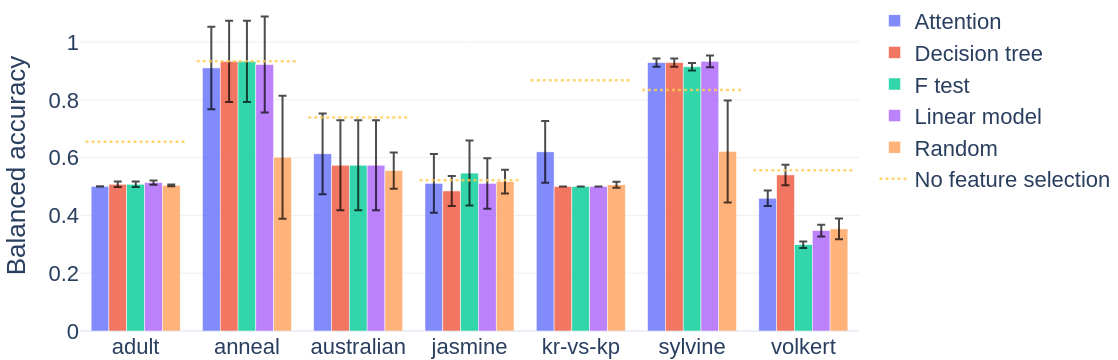

In [188]:
cos_model = "KNN"
cos_feat_percent = 0.1
cos_cluster = "C0"

cos_df = fs_scores_df.query(
    "opt_metric==@OPTIMIZATION_METRIC "
    "and model==@cos_model "
    "and features_percent==@cos_feat_percent "
    "and cluster==@cos_cluster "
)

cos_df = cos_df[[
        "dataset",
        "cluster",
        "selection_method",
        "features_percent",        
        f"{EVALUATION_METRIC}_mean", 
        f"{EVALUATION_METRIC}_std", 
]].replace({"selection_method": fs_name_mapping})


fig = go.Figure(layout=layout)


for sel_method_i, sel_method in enumerate(cos_df["selection_method"].unique()):
    plot_data = cos_df.query("selection_method==@sel_method")
    fig.add_trace(go.Bar(
        name=sel_method, 
        x=plot_data["dataset"], 
        y=plot_data[f"{EVALUATION_METRIC}_mean"],
        error_y=dict(
                    type="data", 
                    array=plot_data[f"{EVALUATION_METRIC}_std"],
                    color="rgba(0, 0, 0, 0.7)"
                    ),
        marker_color=COLORS[sel_method_i]
    ))
    
    
# Adding lines of non feature selection scores    
cos_df = fs_scores_df.query(
    "opt_metric==@OPTIMIZATION_METRIC "
    "and model==@cos_model "
    "and features_percent==1 "
    "and cluster==@cos_cluster "
)
plot_data = cos_df.drop(["selection_method"], axis=1).drop_duplicates()

for ds_i, ds in enumerate(cos_df["dataset"].unique()):
    nfs_metric = plot_data.query("dataset==@ds")[f"{EVALUATION_METRIC}_mean"].values[0]
    fig.add_shape(type="line",
                    x0=ds_i - 0.45,
                    y0=nfs_metric,
                    x1=ds_i + 0.45,
                    y1=nfs_metric,
                    line=dict(color=COLORS[-1], width=2.5, dash="dot"),
                    xref="x",
                    yref="y",
                    name="No feature selection",
                    showlegend=True if ds_i == 0 else False
    )
    
fig.update_layout(
    yaxis_title = "Balanced accuracy"
)

fig.show()
fig.write_image(os.path.join(ASSETS_DIR, f"results_cluster_{cos_model}_{cos_feat_percent}_{cos_cluster}.svg"), scale=IMG_SCALE)

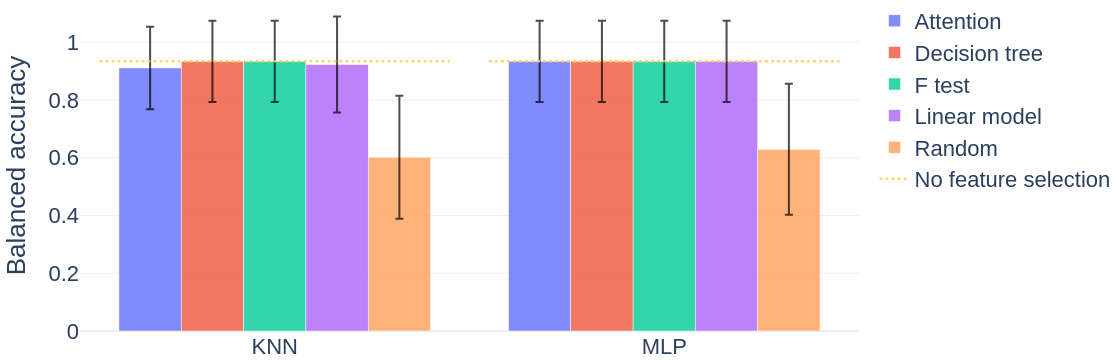

In [189]:
cos_dataset = "anneal"
cos_feat_percent = 0.1
cos_cluster = "C0"

cos_df = fs_scores_df.query(
    "opt_metric==@OPTIMIZATION_METRIC "
    "and dataset==@cos_dataset "
    "and features_percent==@cos_feat_percent "
    "and cluster==@cos_cluster "
)

cos_df = cos_df[[
        "dataset",
        "model",
        "cluster",
        "selection_method",
        "features_percent",        
        f"{EVALUATION_METRIC}_mean", 
        f"{EVALUATION_METRIC}_std", 
]].replace({"selection_method": fs_name_mapping})


fig = go.Figure(layout=layout)

for sel_method_i, sel_method in enumerate(cos_df["selection_method"].unique()):
    plot_data = cos_df.query("selection_method==@sel_method")
    fig.add_trace(go.Bar(
        name=sel_method, 
        x=plot_data["model"], 
        y=plot_data[f"{EVALUATION_METRIC}_mean"],
        error_y=dict(
                    type="data", 
                    array=plot_data[f"{EVALUATION_METRIC}_std"],
                    color="rgba(0, 0, 0, 0.7)"
                    ),
        marker_color=COLORS[sel_method_i]
    ))
    
    
# Adding lines of non feature selection scores    
cos_df = fs_scores_df.query(
    "opt_metric==@OPTIMIZATION_METRIC "
    "and dataset==@cos_dataset "
    "and features_percent==1 "
    "and cluster==@cos_cluster "
)
plot_data = cos_df.drop(["selection_method"], axis=1).drop_duplicates()

for mod_i, mod in enumerate(cos_df["model"].unique()):
    nfs_metric = plot_data.query("model==@mod")[f"{EVALUATION_METRIC}_mean"].values[0]
    fig.add_shape(type="line",
                    x0=mod_i - 0.45,
                    y0=nfs_metric,
                    x1=mod_i + 0.45,
                    y1=nfs_metric,
                    line=dict(color=COLORS[-1], width=2.5, dash="dot"),
                    xref="x",
                    yref="y",
                    name="No feature selection",
                    showlegend=True if mod_i == 0 else False
    )

fig.update_layout(
    yaxis_title = "Balanced accuracy"
)

fig.show()
fig.write_image(os.path.join(ASSETS_DIR, f"results_cluster_{cos_dataset}_{cos_feat_percent}_{cos_cluster}.svg"), scale=IMG_SCALE)

### Cases of study - Full dataset mode

In [191]:
fs_ds_scores_df = pd.read_csv("feature_selection_dataset_scores.csv")
fs_ds_scores_df[["dataset", "cluster"]].drop_duplicates()

,dataset,cluster
0,adult,C0
18,anneal,C0
36,australian,C0
54,jasmine,C0
72,kr-vs-kp,C0
90,sylvine,C0
108,volkert,C0


In [192]:
# Unify random scores
random_scores = fs_ds_scores_df.query("selection_method.str.contains('random')")

random_scores = random_scores.drop(["selection_method"], axis=1)
random_scores = random_scores.groupby(
                    ["dataset", "cluster", "model", "opt_metric", "features_percent", "n_features_selected"], 
                    as_index=False).agg(["mean", "std"])

random_scores.columns = ["_".join(col) if col[1] else col[0] for col in random_scores.columns] 
random_scores = random_scores[[
                    "dataset", "cluster", "model", "opt_metric", "features_percent", "n_features_selected", 
                    "balanced_accuracy_mean_mean", "balanced_accuracy_mean_std",
                    "accuracy_mean_mean", "accuracy_mean_std"
                ]]

random_scores.columns = [
                    "dataset", "cluster", "model", "opt_metric", "features_percent", "n_features_selected",
                    "balanced_accuracy_mean", "balanced_accuracy_std",
                    "accuracy_mean", "accuracy_std"
                ]
random_scores["selection_method"] = "random"

In [193]:
# Set to original dataset
fs_ds_scores_df = pd.concat([
        fs_ds_scores_df.query("not selection_method.str.contains('random')"),
        random_scores
])

#### Executions per dataset

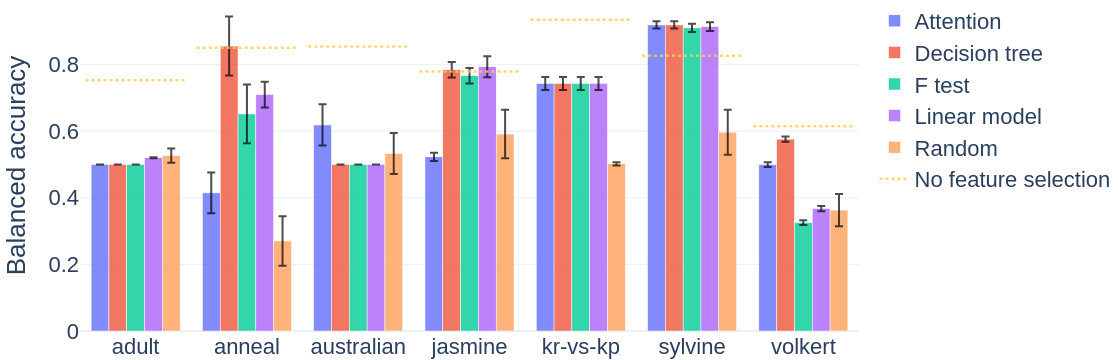

In [195]:
cos_model = "KNN"
cos_feat_percent = 0.1

cos_df = fs_ds_scores_df.query(
    "opt_metric==@OPTIMIZATION_METRIC "
    "and model==@cos_model "
    "and features_percent==@cos_feat_percent "
)

cos_df = cos_df[[
        "dataset",
        "cluster",
        "selection_method",
        "features_percent",        
        f"{EVALUATION_METRIC}_mean", 
        f"{EVALUATION_METRIC}_std", 
]].replace({"selection_method": fs_name_mapping})

fig = go.Figure(layout=layout)

for sel_method_i, sel_method in enumerate(cos_df["selection_method"].unique()):
    plot_data = cos_df.query("selection_method==@sel_method")
    fig.add_trace(go.Bar(
        name=sel_method, 
        x=plot_data["dataset"], 
        y=plot_data[f"{EVALUATION_METRIC}_mean"],
        error_y=dict(
                    type="data", 
                    array=plot_data[f"{EVALUATION_METRIC}_std"],
                    color="rgba(0, 0, 0, 0.7)"
                    ),
        marker_color=COLORS[sel_method_i]
    ))
    
    
# Adding lines of non feature selection scores    
cos_df = fs_ds_scores_df.query(
    "opt_metric==@OPTIMIZATION_METRIC "
    "and model==@cos_model "
    "and features_percent==1 "
)

plot_data = cos_df.drop(["selection_method"], axis=1).drop_duplicates()

for ds_i, ds in enumerate(cos_df["dataset"].unique()):
    nfs_metric = plot_data.query("dataset==@ds")[f"{EVALUATION_METRIC}_mean"].values[0]
    fig.add_shape(type="line",
                    x0=ds_i - 0.45,
                    y0=nfs_metric,
                    x1=ds_i + 0.45,
                    y1=nfs_metric,
                    line=dict(color=COLORS[-1], width=2.5, dash="dot"),
                    xref="x",
                    yref="y",
                    name="No feature selection",
                    showlegend=True if ds_i == 0 else False
    )

fig.update_layout(
    yaxis_title = "Balanced accuracy"
)

fig.show()
fig.write_image(os.path.join(ASSETS_DIR, f"results_dataset_{cos_model}_{cos_feat_percent}.svg"), scale=IMG_SCALE)